Import libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
#!conda install -c conda-forge geocoder --yes
#import geocoder
print('Ready!')

Ready!


Use BeautifulSoup to scrape the Wikipedia page for postal codes and corresponding neighbourhoods, and transfer the data into a dataframe. Exclude any data where the neighbourhood is "Not assigned" or the postal code contains a 0 (this is usually reserved for rural areas) 

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H').text
soup = BeautifulSoup(source, 'html5lib')
table = soup.find('table')
columns = ['PostalCode','Neighbourhood']
montreal_data = pd.DataFrame(columns=columns)
for table_cell in table.find_all('td'):
    try:
        postal_code = table_cell.p.b.text
        nhoods_data = list(table_cell.span.text)
        try:
            for i in range(len(nhoods_data)):
                if nhoods_data[i+1].isupper() == True and nhoods_data[i].islower() == True and nhoods_data[i-1].islower():
                    nhoods_data.insert(i+1, ' ')
        except:
            pass
        nhoods_data = ''.join(nhoods_data)
        nhoods_data = nhoods_data.split('(')[0]
        nhoods_data = nhoods_data.split('/')[0]
        if nhoods_data != 'Not assigned' and postal_code[1] != '0':
            montreal_data = montreal_data.append({"PostalCode": postal_code, "Neighbourhood": nhoods_data}, ignore_index=True)        
    except:
        pass
montreal_data.shape

(121, 2)

Read geographic coordinates for each postal code from a csv file and add them to the dataframe.

In [3]:
csv_file = pd.read_csv('https://raw.githubusercontent.com/rjabbar/Capstone-project/master/Geospatial_Coordinates.csv')
csv_file
montreal_data['Latitude'] = csv_file['Latitude']
montreal_data['Longitude'] = csv_file['Longitude']
montreal_data.head()

,PostalCode,Neighbourhood,Latitude,Longitude
0,H1A,Pointe-aux-Trembles,45.676787,-73.509836
1,H2A,Saint-Michel East,45.565481,-73.596238
2,H3A,Downtown Montreal North,45.503706,-73.576872
3,H4A,Notre-Dame-de-Grâce Northeast,45.471749,-73.614135
4,H5A,Place Bonaventure,45.500074,-73.565398


Use geolocator to get the geographic coordinates of Montreal.

In [4]:
address = 'Montreal, QC'
geolocator = Nominatim(user_agent="qc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographic coordinates of Montreal are {}, {}.'.format(latitude, longitude))

The geographic coordinates of Montreal are 45.4972159, -73.6103642.


Use Folium to produce a map of Montreal with the various neighbourhoods from the dataframe superimposed on it.

In [5]:
map_montreal = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, neighbourhood in zip(montreal_data['Latitude'], montreal_data['Longitude'], montreal_data['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_montreal)  
map_montreal

Obtain credentials for Foursquare (hidden cell)

In [6]:
# @hidden_cell
CLIENT_ID = 'EM1C5BDZ2NDWTJJQIJ003TB1P13ZDIKOKBGU0BFOW4DDHAK5' 
CLIENT_SECRET = 'D0ROEYHSYCUXH4ZAF3YNDJQFZJQGM3WDH40PN4GQTIFTCNTJ' 
VERSION = '20180605' 

Define a function getNearbyVenues which gathers a maximum of 100 venues within a 500 m radius of a given location, and returns a dataframe with location data pertaining to each venue.

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    radius = 500
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)   
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']    
    return(nearby_venues)

Use getNearbyVenues to gather venue data for all of the neighbourhoods in Montreal.

In [9]:
montreal_venues = getNearbyVenues(names=montreal_data['Neighbourhood'], latitudes=montreal_data['Latitude'], longitudes=montreal_data['Longitude'])
montreal_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Saint-Michel East,45.565481,-73.596238,"1,000,000 Comix",45.565233,-73.592580,Bookstore
1,Saint-Michel East,45.565481,-73.596238,La Table Fleurie,45.562740,-73.594870,Cupcake Shop
2,Saint-Michel East,45.565481,-73.596238,Bar 4040,45.566041,-73.591691,Bar
3,Saint-Michel East,45.565481,-73.596238,café malouf,45.566452,-73.591583,Café
4,Saint-Michel East,45.565481,-73.596238,Café-resto Sidi Bou Saïd,45.562116,-73.595454,Middle Eastern Restaurant


Sort through the venues data and count the number of venues per neighbourhood. Retain the neighbourhoods that have at least 10 venues for further analysis.

In [10]:
mtl_data = pd.DataFrame(columns=['PostalCode','Neighbourhood','Latitude','Longitude'])
k = 0
for i in range(len(montreal_data)):
    for j in range(len(montreal_venues)):
        if montreal_venues.iloc[j,0] == montreal_data.iloc[i,1]:
            k = k + 1
    if k >= 10:
        mtl_data = mtl_data.append({'PostalCode': montreal_data['PostalCode'][i], 'Neighbourhood': montreal_data['Neighbourhood'][i], 'Latitude': montreal_data['Latitude'][i], 'Longitude': montreal_data['Longitude'][i]}, ignore_index=True)
        k = 0
mtl_data.shape

(55, 4)

Run getNearbyVenues on the new dataframe of neighbourhoods.

In [11]:
mtl_venues = getNearbyVenues(names=mtl_data['Neighbourhood'], latitudes=mtl_data['Latitude'], longitudes=mtl_data['Longitude'])

Perform one hot encoding on the venues data.

In [12]:
# one hot encoding
montreal_onehot = pd.get_dummies(mtl_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
montreal_onehot['Neighbourhood'] = mtl_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [montreal_onehot.columns[-1]] + list(montreal_onehot.columns[:-1])
montreal_onehot = montreal_onehot[fixed_columns]

montreal_grouped = montreal_onehot.groupby('Neighbourhood').mean().reset_index()
montreal_grouped.head()

,Neighbourhood,ATM,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,...,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Ahuntsic Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.052632,0.000000,0.0,0.000000,0.0
1,Ahuntsic Southeast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.083333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.0
2,Ahuntsic Southwest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.066667,0.0,0.000000,0.0
3,Anjou East,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,Centre-Sud North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.041667,0.000000,0.0,0.000000,0.0


Define a function return_most_common_venues which identifies the top 10 venue category types for a given location, and use it to sort the neighbourhoods.

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = montreal_grouped['Neighbourhood']

for ind in np.arange(montreal_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(montreal_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahuntsic Central,Café,Bakery,Pharmacy,Grocery Store,Breakfast Spot,Sushi Restaurant,Organic Grocery,Bar,Restaurant,Dessert Shop
1,Ahuntsic Southeast,Italian Restaurant,Park,Train Station,Bank,Café,Restaurant,Grocery Store,Clothing Store,Sandwich Place,Pharmacy
2,Ahuntsic Southwest,Pharmacy,Pizza Place,Park,Farmers Market,New American Restaurant,Café,Beer Store,Lounge,Bakery,Restaurant
3,Anjou East,Convenience Store,Soccer Field,Park,American Restaurant,Cajun / Creole Restaurant,Falafel Restaurant,Factory,Farmers Market,Discount Store,English Restaurant
4,Centre-Sud North,French Restaurant,Park,Sandwich Place,Performing Arts Venue,Café,Gym Pool,Gas Station,Metro Station,Bakery,Mexican Restaurant


Determine the optimum number of clusters for k-means clustering using the elbow method.

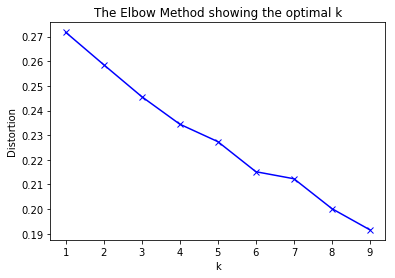

In [14]:
distortions = []
K = range(1,10)
montreal_grouped_clustering = montreal_grouped.drop('Neighbourhood', 1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(montreal_grouped_clustering)
    distortions.append(sum(np.min(cdist(montreal_grouped_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)) / montreal_grouped_clustering.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the elbow method, the optimum number of clusters is 4. Use this to perform k-means clustering on the sorted neighbourhoods data.

In [15]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(montreal_grouped_clustering)

Merge the neighbourhoods dataframe with the newly generated top 10 venues dataframe, which now includes cluster labels.

In [16]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
montreal_merged = mtl_data
montreal_merged = montreal_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how='right')
montreal_merged.head()

,PostalCode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,H3A,Downtown Montreal North,45.503706,-73.576872,1,Hotel,Sandwich Place,Coffee Shop,Pizza Place,Clothing Store,Restaurant,French Restaurant,Shopping Mall,Café,Spa
1,H4A,Notre-Dame-de-Grâce Northeast,45.471749,-73.614135,1,Café,BBQ Joint,Persian Restaurant,Indian Restaurant,Bakery,Breakfast Spot,Convenience Store,Pub,Coffee Shop,Park
2,H5A,Place Bonaventure,45.500074,-73.565398,1,Hotel,Coffee Shop,Gastropub,Cocktail Bar,Plaza,Steakhouse,French Restaurant,Deli / Bodega,Cosmetics Shop,Clothing Store
3,H3B,Downtown Montreal East,45.499922,-73.568950,1,Coffee Shop,Café,Hotel,Clothing Store,Deli / Bodega,Steakhouse,Gastropub,Pizza Place,Restaurant,Portuguese Restaurant
4,H4B,Notre-Dame-de-Grâce Southwest,45.459975,-73.634259,1,Sandwich Place,Greek Restaurant,Hotel,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Skating Rink,Bus Stop,Café,Gym / Fitness Center


Produce a new map of Montreal using Folium with the clusters superimposed on it.

In [17]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(montreal_merged['Latitude'], montreal_merged['Longitude'], montreal_merged['Neighbourhood'], montreal_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Identify the largest cluster and produce horizontal bar charts which show the categories of the 1st, 2nd, and 3rd most common venues in this cluster.

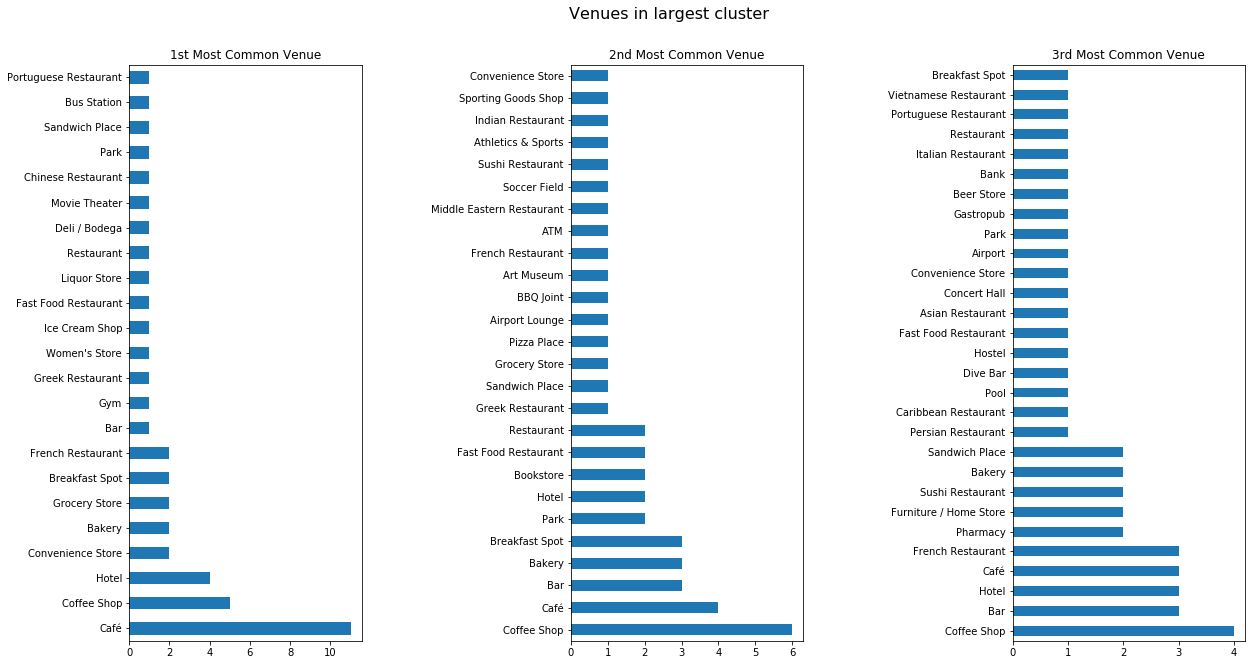

In [18]:
label_counts = montreal_merged['Cluster Labels'].value_counts()
ind = label_counts.index[0]
cluster = montreal_merged.loc[montreal_merged['Cluster Labels'] == ind, montreal_merged.columns[[1] + list(range(5, montreal_merged.shape[1]))]]
categorical_features = ["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue"]
fig, ax = plt.subplots(1, len(categorical_features), figsize=(20,10))
for i, categorical_feature in enumerate(cluster[categorical_features]):
    cluster[categorical_feature].value_counts().plot("barh", ax=ax[i]).set_title(categorical_feature)
fig.suptitle('Venues in largest cluster', fontsize=16)
fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.9, hspace=0.2)
fig.show()